In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as colors
import numpy as np
import dateutil
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
fr_raw = pd.read_csv(r'..\data\search\peak_finder\Final_Results.csv').dropna(axis=1, how='all')
fr_norm = pd.read_csv(r'..\data\processed\lipidomics_linregress_normalized_data.csv')
fr_filt = pd.read_csv(r'..\data\processed\lipidomics_normalized_filtered_data.csv', index_col=0)
file_grouping = pd.read_csv(r'..\data\metadata\file_grouping.csv', index_col=0)

fr_quant_filenames_in_analytical_order = file_grouping[file_grouping['quant_file'] == True]['fr_name'].to_list()

animals_used = [1091, 1093, 1060, 1062, 1074, 1092, 1102, 1076, 1082, 1101]
diabetic = [1076, 1082, 1101]
impaired = [1060, 1062, 1074, 1092, 1102]
normal = [1091, 1093]

obs = pd.read_excel(r'..\data\metadata\20210421_FBGRBGOGTT_Huishi sample sheet.xlsx', sheet_name='cleaned')
obs['animal'] = obs['animal'].str.strip('TM').astype('int')
obs['datetime'] = obs['when'].apply(dateutil.parser.parse)
animal_phenotypes = pd.read_excel(r'..\data\metadata\20210421_FBGRBGOGTT_Huishi sample sheet.xlsx', sheet_name='animal phenotypes')
animal_phenotypes['animal'] = animal_phenotypes['animal'].str.strip('TM').astype('int')

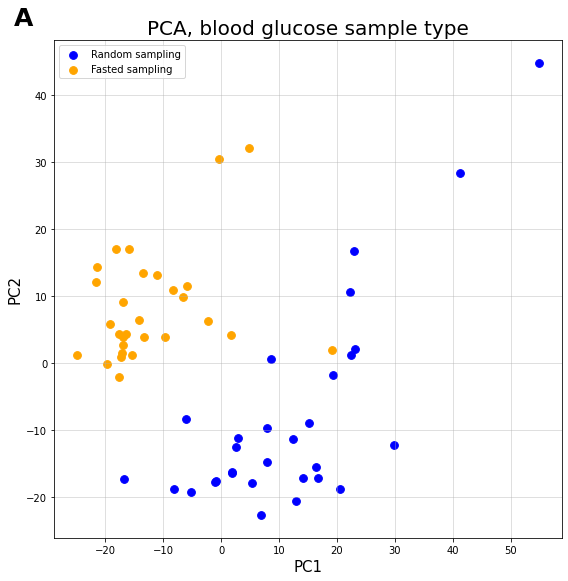

In [24]:
df = fr_filt

pca_data = df.drop(df.filter(regex='Blank|Water|QC1|QC2').columns, axis=1).filter(regex='.raw').T

# Populate rat_label and bg_type columns in PCA df from file_grouping
# (pd.merge() is similar to inner join in SQL) 
pca_data = pd.merge(pca_data, 
                    file_grouping[['fr_name', 'rat_label', 'bg_type']],
                    how='inner', 
                    left_on=pca_data.index, 
                    right_on='fr_name',)\
                    .set_index(pca_data.index).drop('fr_name', axis=1)

n_components = 2
pca = PCA(n_components=n_components)

# Standard scaler is a little important for PCA
scaled = StandardScaler().fit_transform(pca_data.drop(['bg_type', 'rat_label'], axis=1))
fitted = pca.fit_transform(scaled)
# auto-name PCA columns as pc1, pc2... based on n_components
columns = ['pc' + str(x) for x in range(1, n_components + 1)]
fitted = pd.DataFrame(fitted, columns=columns)

# restore the bg and rat labels into the df
pca_data = pd.concat([fitted, pca_data.reset_index()[['bg_type', 'rat_label']]], axis=1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)
ax.set_title('PCA, blood glucose sample type', fontsize=20)
targets = ['RBG', 'FBG']
target_colors = ['blue', 'orange']
markers = ['o', 's']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
          'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
# colors = [plt.get_cmap('Dark2')(i) for i in range(1, 11)]

for target, color in zip(targets, target_colors):
    scatter_points = pca_data[(pca_data['bg_type'] == target)] 
    ax.scatter(scatter_points['pc1'],
               scatter_points['pc2'],
               c = color,
               cmap='viridis',
               s = 60)
ax.legend(['Random sampling', 'Fasted sampling'],)
ax.grid(alpha=0.5)
plt.tight_layout()

ax.text(-0.08, 1.03, "A", transform=ax.transAxes, fontsize=25, weight='bold')

plt.savefig(r'..\reports\collaborator reports\preliminary 20210812\figures\PCA colored by BG.png')

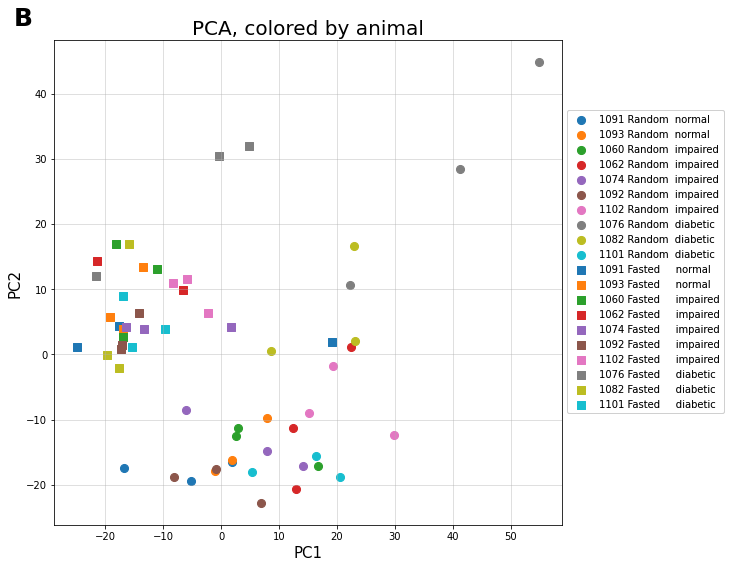

In [23]:
df = fr_filt

pca_data = df.drop(df.filter(regex='Blank|Water|QC1|QC2').columns, axis=1).filter(regex='.raw').T

# Populate rat_label and bg_type columns in PCA df from file_grouping
# (pd.merge() is similar to inner join in SQL) 
pca_data = pd.merge(pca_data, 
                    file_grouping[['fr_name', 'rat_label', 'bg_type']],
                    how='inner', 
                    left_on=pca_data.index, 
                    right_on='fr_name',)\
                    .set_index(pca_data.index).drop('fr_name', axis=1)

n_components = 2
pca = PCA(n_components=n_components)

# Standard scaler is a little important for PCA
scaled = StandardScaler().fit_transform(pca_data.drop(['bg_type', 'rat_label'], axis=1))
fitted = pca.fit_transform(scaled)
# auto-name PCA columns as pc1, pc2... based on n_components
columns = ['pc' + str(x) for x in range(1, n_components + 1)]
fitted = pd.DataFrame(fitted, columns=columns)

# restore the bg and rat labels into the df
pca_data = pd.concat([fitted, pca_data.reset_index()[['bg_type', 'rat_label']]], axis=1)

# display(pca_data)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)
ax.set_title('PCA, colored by animal', fontsize = 20)
targets = ['RBG', 'FBG']
markers = ['o', 's']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
          'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
# colors = [plt.get_cmap('Dark2')(i) for i in range(1, 11)]

handles = []

for target, marker in zip(targets, markers):
    for label, color in zip(animals_used, colors):
        scatter_points = pca_data[(pca_data['bg_type'] == target) & (pca_data['rat_label'] == label)]
#         print(scatter_points)
        handle = ax.scatter(scatter_points['pc1'],
                            scatter_points['pc2'],
                            c = color,
#                             cmap='viridis',
                            marker=marker,
                            s = (75 if marker == 's' else 65),
                            )
    
        # define the text label for the data handle for the legend:
        gluc_tol = animal_phenotypes[animal_phenotypes['animal'] == label]['glucose_tolerance'].values[0]
        handle.set_label(str(label) + ' ' + ('Random ' if target == 'RBG' else 'Fasted    ') + ' ' + gluc_tol)
        handles.append(handle)
        
# ax.legend(['RBG sample', 'FBG sample'],)
ax.grid(alpha=0.5)
plt.tight_layout()

legend_labels = []
for animal in animals_used:
    animal_data = animal_phenotypes[animal_phenotypes['animal'] == animal]
    gluc_tol = animal_data['glucose_tolerance'].values[0]
    label = str(animal) + ' ' + gluc_tol
    legend_labels.append(label)
    
# Sort legend_labels based on normal/impaired/diabetic substring
# legend_labels.sort(key = lambda x: x.split(' ')[1])

handles, labels = ax.get_legend_handles_labels()

# print(handles, labels)
legend = ax.legend(handles, labels, loc=(1.01, 0.23))

# legend = ax.legend(labels=legend_labels, loc=(1.01, 0.7))
ax.add_artist(legend)
# ax.legend(handles=[mpatches.Rectangle(xy=(0, 0), width=1, height=1, color='black', label='FBG'),
#                    mpatches.Circle(xy=(0, 0), color='black', label='RBG')])

ax.text(-0.08, 1.03, "B", transform=ax.transAxes, fontsize=25, weight='bold')
# ax.text(1.072, 0.87, "Animal, feeding, glucose tolerance", transform=ax.transAxes, fontsize=9)

plt.tight_layout()

plt.savefig(r'..\reports\collaborator reports\preliminary 20210812\figures\PCA colored by animal.png', 
            bbox_inches='tight')  

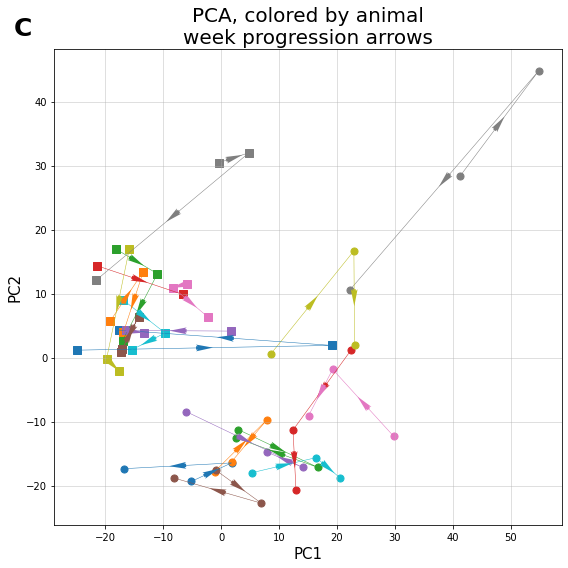

In [9]:
df = fr_filt

pca_data = df.drop(df.filter(regex='Blank|Water|QC1|QC2').columns, axis=1).filter(regex='.raw').T

# Populate rat_label and bg_type columns in PCA df from file_grouping
# (pd.merge() is similar to inner join in SQL) 
pca_data = pd.merge(pca_data, 
                    file_grouping[['fr_name', 'rat_label', 'bg_type']],
                    how='inner', 
                    left_on=pca_data.index, 
                    right_on='fr_name',)\
                    .set_index(pca_data.index).drop('fr_name', axis=1)

n_components = 2
pca = PCA(n_components=n_components)

# Standard scaler is a little important for PCA
scaled = StandardScaler().fit_transform(pca_data.drop(['bg_type', 'rat_label'], axis=1))
fitted = pca.fit_transform(scaled)
# auto-name PCA columns as pc1, pc2... based on n_components
columns = ['pc' + str(x) for x in range(1, n_components + 1)]
fitted = pd.DataFrame(fitted, columns=columns)

# restore the bg and rat labels into the df
pca_data = pd.concat([fitted, pca_data.reset_index()[['bg_type', 'rat_label']]], axis=1)

# display(pca_data)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)
ax.set_title('PCA, colored by animal\nweek progression arrows', fontsize = 20)
targets = ['RBG', 'FBG']
markers = ['o', 's']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
          'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
# colors = [plt.get_cmap('Dark2')(i) for i in range(1, 11)]

for target, marker in zip(targets, markers):
    for label, color in zip(animals_used, colors):
        scatter_points = pca_data[(pca_data['bg_type'] == target) & (pca_data['rat_label'] == label)]
#         print(scatter_points)
        ax.scatter(scatter_points['pc1'],
                   scatter_points['pc2'],
                   c = color,
#                    cmap='viridis',
                   marker=marker,
                   s = (60 if marker == 's' else 50),
                   )
        # Adding arrows connecting each mouse from week 8 to 9 to 10 using ax.quiver()
        # https://stackoverflow.com/questions/58342419/show-direction-arrows-in-a-scatterplot
        
        x = scatter_points['pc1'].values
        y = scatter_points['pc2'].values
        
        x_diff = np.diff(x)
        y_diff = np.diff(y)
        
        pos_x = x[:-1] + x_diff/2
        pos_y = y[:-1] + y_diff/2
                
        norm = np.sqrt(x_diff**2 + y_diff**2)
        
        ax.quiver(pos_x, pos_y, x_diff/norm, y_diff/norm, angles='xy', zorder=5, pivot='mid', 
                  color=color,
                  linewidth=0.01,
#                   linestyle='-',
                  scale=30,
                  headwidth=2,
                 )
        plt.plot(x, y, linewidth=0.5)
    
# ax.legend(['RBG sample', 'FBG sample'],)
ax.grid(alpha=0.5)
plt.tight_layout()

ax.text(-0.08, 1.03, "C", transform=ax.transAxes, fontsize=25, weight='bold')

plt.savefig(r'..\reports\collaborator reports\preliminary 20210812\figures\PCA colored by animal arrows.png')  

           pc1     Identification
781   0.054090       PC 18:2_19:0
425   0.053830       PC 18:2_22:6
805   0.053222       PC 16:0_18:0
836   0.052782            PC 40:3
815   0.052490       PC 18:1_18:0
...        ...                ...
196  -0.028276            AC 18:0
967  -0.028826  TG 20:5_22:6_22:6
1000 -0.033249  TG 18:2_20:5_20:5
154  -0.036121            AC 18:1
143  -0.037360            AC 16:0

[324 rows x 2 columns]
(324, 2)


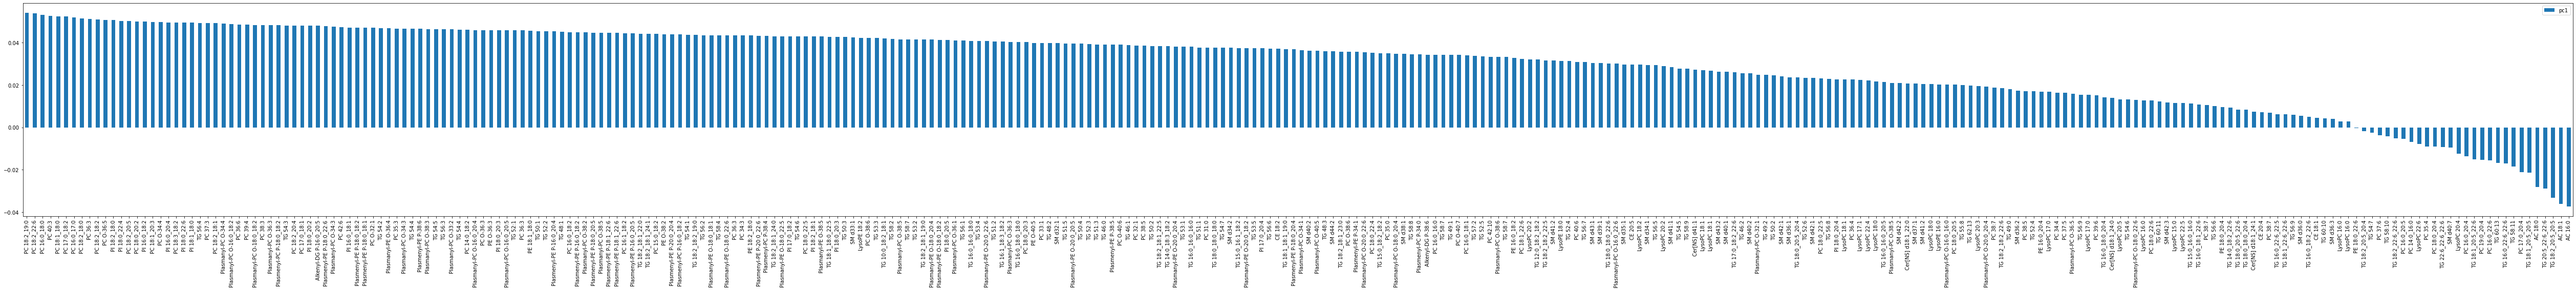

In [20]:
loadings = pd.DataFrame(pca.components_.T, columns=['pc1', 'pc2'], index=fr_norm.index)
loadings = loadings.merge(fr_raw, how='inner', left_index=True, right_index=True)
loadings = loadings[loadings['Identification'].notnull()].sort_values('pc1', ascending=False)[['pc1', 'Identification']]

print(loadings)

loadings.iloc[:].plot.bar()
print(loadings.shape)
# print(loadings['Identification'].values)
plt.xticks(list(range(0, loadings.shape[0])), loadings['Identification'].values, rotation=90);

plt.gcf().set_size_inches(70, 8)

plt.tight_layout()

plt.savefig(r'..\reports\figures\pc1 loadings.png')

<BarContainer object of 324 artists>

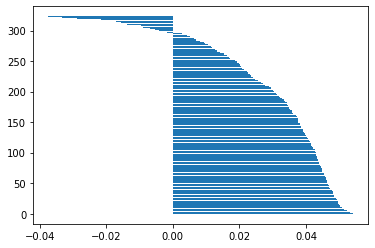

In [22]:
plt.barh(list(range(0,loadings.shape[0])), loadings['pc1'].values)

No handles with labels found to put in legend.


(324, 3)


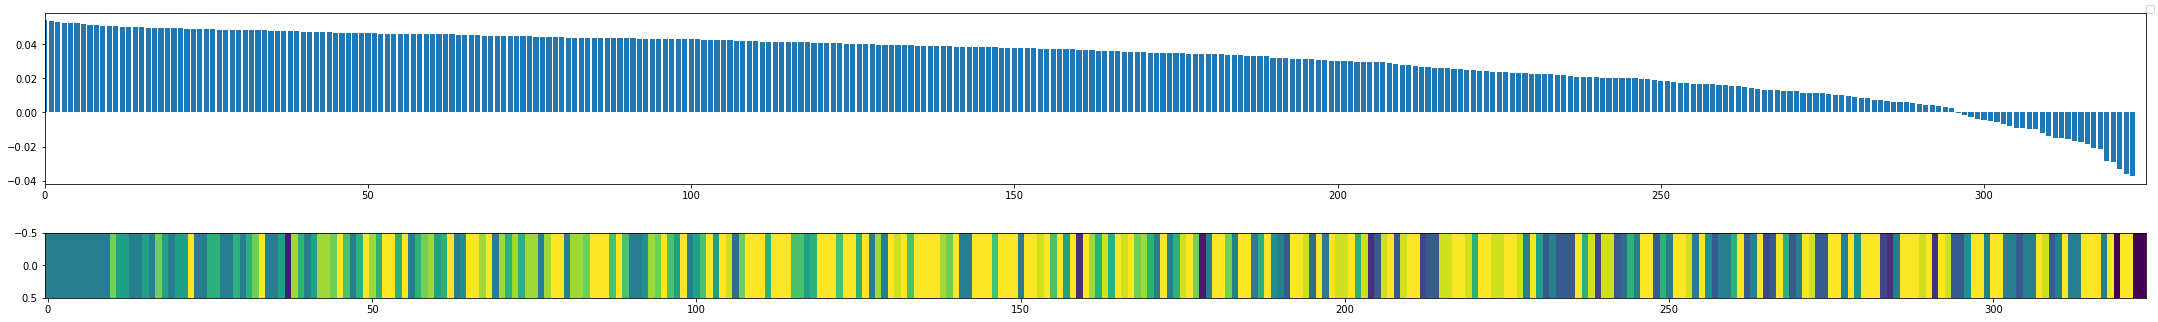

In [25]:
# Generate mapping from lipid class to a number for plt.imshow()
unique_classes = sorted(list(fr_norm['Lipid Class'].unique()))
lip_class_num_map = {}
for i, lip_class in enumerate(unique_classes):
    lip_class_num_map[lip_class] = i
    
    

loadings = pd.DataFrame(pca.components_.T, columns=['pc1', 'pc2'], index=fr_norm.index)
loadings = loadings.merge(fr_raw, how='inner', left_index=True, right_index=True)
loadings = loadings[loadings['Identification'].notnull()].sort_values('pc1', ascending=False)[['pc1', 'Identification', 'Lipid Class']]

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(30, 5))

ax1.bar(list(range(0, loadings.shape[0])), loadings['pc1'].values)
ax1.set_xlim(0, 325)

# Create list to plot in .imshow()
values = []
for lip_class in loadings[loadings['Lipid Class'] != 'unknown']['Lipid Class']:
    values.append(lip_class_num_map[lip_class])

# bounds = np.arange(-0.5, len(values), 1)
# norm = colors.BoundaryNorm(boundaries=bounds,)
  
    
ims = ax2.imshow([values], aspect=10)

# fig.colorbar(ims, ax=ax2, orientation='horizontal')

fig.legend()

# ax1.barh(loadings['pc1'])

# loadings.iloc[:].plot.bar()
print(loadings.shape)
# print(loadings['Identification'].values)
# plt.xticks(list(range(0, loadings.shape[0])), loadings['Identification'].values, rotation=90);

plt.tight_layout()

# plt.savefig(r'..\reports\figures\pc1 loadings.png')

### Color the loadings plot by Lipid Class and Lipid Superclass to show by color which classes drive the difference between FBG and RBG

##### Colorbar doesn't work
##### Use heatmap instead

In [318]:
unique_classes = sorted(list(fr_norm['Lipid Class'].unique()))

lip_class_num_map = {}

for i, lip_class in enumerate(unique_classes):
    lip_class_num_map[lip_class] = i

In [327]:
fr_norm[fr_norm['Lipid Class'] != 'unknown']['Lipid Class']

92      LysoPC
95      LysoPC
100     LysoPC
106     LysoPC
108     LysoPC
         ...  
1465        TG
1468        TG
1469        TG
1471        TG
1473        TG
Name: Lipid Class, Length: 324, dtype: object

In [19]:
values = []
print(values)

for lip_class in fr_norm[fr_norm['Lipid Class'] != 'unknown']['Lipid Class']:
#     print(lip_class)
    values.append(lip_class_num_map[lip_class])
    
print(values)
plt.imshow([values], aspect=10)
plt.gcf().set_size_inches(40, 5)
    

[]


NameError: name 'lip_class_num_map' is not defined

In [ ]:
loadings = pd.DataFrame(pca.components_.T, columns=['pc1', 'pc2'], index=fr_norm.index)
loadings = loadings.merge(fr_raw, how='inner', left_index=True, right_index=True)
loadings[loadings['Identification'].notnull()].sort_values('pc1', ascending=False)['pc1'].plot.bar()
plt.xticks([], [])

In [219]:
fr_raw

,Retention Time (min),Quant Ion,Polarity,Area (max),Identification,Lipid Class,Features Found,20210729_AJ_Toh_RatBloodGlucose_ExtractionBlank.raw (F1),20210729_AJ_Toh_RatBloodGlucose_SolventBlank.raw (F2),20210729_AJ_Toh_RatBloodGlucose_T1060M_20210322_8wk_FBG.raw (F3),...,20210729_AJ_Toh_RatBloodGlucose_T1102M_20210327_8wk_FBG.raw (F59),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210330_8wk_RBG.raw (F60),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210402_9wk_FBG.raw (F61),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210406_9wk_RBG.raw (F62),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210410_10wk_FBG.raw (F63),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210413_10wk_RBG.raw (F64),20210729_AJ_Toh_RatBloodGlucose_Water_R1.raw (F65),20210729_AJ_Toh_RatBloodGlucose_Water_R2.raw (F66),20210729_AJ_Toh_RatBloodGlucose_Water_R3.raw (F67),Unnamed: 74
0,0.536,679.05463,+,2.408421e+07,NaN,NaN,49,6939.264074,7204.617522,1.145548e+07,...,1.647246e+07,1.366983e+07,1.568381e+07,1.290439e+07,1.353820e+07,1.360893e+07,8616.499626,7755.590041,7473.385618,NaN
1,0.537,641.10870,+,5.522238e+07,NaN,NaN,36,4957.644286,5147.221739,4.677270e+07,...,4.172903e+07,6.220326e+06,4.279894e+07,3.789880e+07,3.219858e+07,2.889174e+07,5992.201567,5261.096948,5307.954232,NaN
2,0.541,951.15973,-,3.238113e+07,NaN,NaN,10,31210.491250,6708.897037,1.625939e+07,...,1.912593e+07,1.216820e+07,2.036861e+07,1.952822e+07,1.953922e+07,1.543462e+07,9861.409380,94752.403070,72744.082630,NaN
3,0.542,329.03067,-,2.882770e+08,NaN,NaN,55,35414.640900,7612.606206,1.290199e+08,...,1.142664e+08,1.452781e+08,1.763549e+08,2.236196e+08,1.790767e+08,1.651242e+08,235854.330500,107515.844600,82542.935410,NaN
4,0.544,969.13147,-,1.697296e+07,NaN,NaN,14,36157.660320,7772.323038,1.089197e+07,...,8.023917e+06,4.351532e+06,1.132409e+07,1.040661e+07,8.373267e+06,9.059848e+06,240802.689200,109771.588600,84274.733400,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1482,20.175,593.58716,+,3.296976e+06,NaN,NaN,19,13463.679470,14827.939600,1.801313e+06,...,1.291650e+06,2.886770e+05,8.545798e+05,6.331233e+05,1.647502e+06,2.088592e+05,15946.120300,15354.653040,15239.583030,NaN
1483,20.196,871.80945,+,2.595829e+06,NaN,NaN,6,11170.753640,11883.403090,1.053780e+06,...,8.523295e+05,8.869149e+04,4.884374e+05,1.233201e+05,1.052764e+06,4.261791e+04,12779.535150,11523.481420,11266.124030,NaN
1484,20.435,1003.93829,+,3.203813e+06,NaN,NaN,4,12695.823470,13819.097200,5.844701e+05,...,3.890957e+05,7.912981e+05,1.910285e+05,1.147269e+06,4.434897e+05,5.509051e+05,23229.657890,14761.180040,17844.172830,NaN
1485,20.452,1164.01404,+,3.204960e+06,NaN,NaN,2,13749.188890,14296.409340,1.669550e+04,...,2.039074e+04,7.236153e+05,3.054687e+04,1.097559e+06,2.851977e+04,5.293939e+05,24032.011160,15271.031760,18460.511230,NaN


(array([[  0.,   9.,  43., 124., 139., 153., 172., 222., 272.,   2.],
        [ 22., 116., 159., 164., 112., 101., 125., 132., 126.,  79.]]),
 array([-0.04754088, -0.03652007, -0.02549926, -0.01447845, -0.00345764,
         0.00756317,  0.01858398,  0.02960479,  0.0406256 ,  0.05164641,
         0.06266722]),
 <a list of 2 BarContainer objects>)

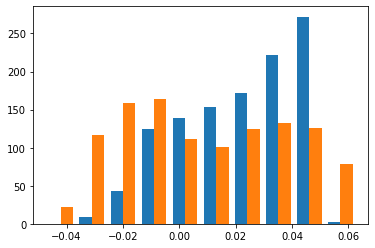

In [98]:
## LOADINGS PLOT OF PCA
plt.hist(pca.components_.T)

In [99]:
pca.explained_variance_

array([336.62610657, 230.25616134])

(array([ 12.,  35.,  79., 123., 106., 113., 130., 152., 241., 145.]),
 array([-0.59696445, -0.44064972, -0.284335  , -0.12802028,  0.02829445,
         0.18460917,  0.3409239 ,  0.49723862,  0.65355335,  0.80986807,
         0.9661828 ]),
 <BarContainer object of 10 artists>)

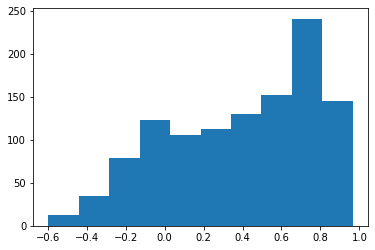

In [100]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
plt.hist(loadings[:, 0])